In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import seaborn as sns
import statsmodels.api as sm

from longitudinal.settings.constants import DATA_PATH

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the raw datasets
gen1_train = pd.read_csv(DATA_PATH + "gen1_train_comp_final.csv")
gen1_test = pd.read_csv(DATA_PATH + "gen1_test_comp_final.csv")
gen2_train = pd.read_csv(DATA_PATH + "gen2_train_comp_final.csv")
gen2_test_upto9 = pd.read_csv(DATA_PATH + "gen2_test_upto9_comp_final.csv")

gen1_train['Height_Velocity'] = gen1_train.groupby('gen1_id')['SHgt_cm'].diff()
gen2_puberty = gen2_train[(gen2_train['AgeGr'] >= 9) & (gen2_train['AgeGr'] <= 15)].copy()
gen2_puberty['Height_Velocity'] = gen2_puberty.groupby('gen2_id')['SHgt_cm'].diff()

In [3]:
gen1_train.head(2)

,gen1_id,sex_assigned_at_birth,age,SHgt_cm,Height_Velocity
0,774,F,0.10,56.961812,NaN
1,774,F,0.25,64.826190,7.864377


In [4]:
gen2_train.head(2)

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,3012,M,mother,636,0.10,56.251625,4.636903
1,3012,M,mother,636,0.25,64.491579,NaN


In [5]:
gen1_genders = gen1_train[["gen1_id", "sex_assigned_at_birth"]].drop_duplicates()

gen2_train["study_parent_sex"] = gen2_train["study_parent_id_new"].map({
    id: val for id, val in zip(gen1_genders["gen1_id"].values, gen1_genders["sex_assigned_at_birth"].values)
}).map({"M": 1, "F": 0})
gen2_train["sex_assigned_at_birth"] = gen2_train["sex_assigned_at_birth"].map({"M": 1, "F": 0})

In [6]:
gen2_train.sample(5)

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
709,2767,1,0.0,549,1.50,84.811876,NaN
3182,2573,0,1.0,638,10.00,139.820064,25.492012
3380,2556,1,1.0,495,10.00,135.992458,28.620832
4005,2514,1,1.0,469,0.25,67.777098,NaN
3965,2516,0,0.0,750,1.50,84.624405,NaN


In [7]:
growth_threshold = gen2_puberty['Height_Velocity'].quantile(0.75)

puberty_onset = (
    gen2_puberty[
        gen2_puberty['Height_Velocity'] > growth_threshold
    ]
    .groupby('gen2_id')['AgeGr']
    .min()
    .reset_index()
)

puberty_onset.columns = ['gen2_id', 'Puberty_Onset_Age']

puberty_duration = (
    gen2_puberty[
        gen2_puberty['Height_Velocity'] > growth_threshold
    ]
    .groupby('gen2_id')['AgeGr']
    .count()
    .reset_index()
)

puberty_duration.columns = ['gen2_id', 'Puberty_Duration']
gen2_puberty_info = puberty_onset.merge(puberty_duration, on='gen2_id')
gen2_puberty_info.head()

,gen2_id,Puberty_Onset_Age,Puberty_Duration
0,2331,11.0,3
1,2507,12.0,1
2,2509,11.0,2
3,2510,14.0,1
4,2512,12.0,2


In [8]:
puberty_onset

,gen2_id,Puberty_Onset_Age
0,2331,11.0
1,2507,12.0
2,2509,11.0
3,2510,14.0
4,2512,12.0
...,...,...
137,2819,12.0
138,2827,11.0
139,2829,11.0
140,2830,11.0


In [11]:
gen1_features = (
    gen1_train
    .groupby('gen1_id')
    .agg(
        Final_Height=('SHgt_cm', 'max'),
        Max_Growth_Rate=('Height_Velocity', 'max'),
        Peak_Growth_Age=('age', lambda x: x.iloc[np.argmax(gen1_train.loc[x.index, 'Height_Velocity'])]),
    ).reset_index()
)

gen1_features.rename(columns={'gen1_id': 'study_parent_id_new'}, inplace=True)

merged_data = (
    gen2_puberty_info
    .merge(gen2_train[['gen2_id', 'study_parent_id_new']], on='gen2_id')
    .merge(gen1_features, on='study_parent_id_new')
    .merge(gen2_train[["gen2_id", "sex_assigned_at_birth", "study_parent_sex"]], on="gen2_id")
)

merged_data.head()

,gen2_id,Puberty_Onset_Age,Puberty_Duration,study_parent_id_new,Final_Height,Max_Growth_Rate,Peak_Growth_Age,sex_assigned_at_birth,study_parent_sex
0,2509,11.0,2,694,188.107978,8.263564,4.0,0,1.0
1,2509,11.0,2,694,188.107978,8.263564,4.0,0,1.0
2,2509,11.0,2,694,188.107978,8.263564,4.0,0,1.0
3,2509,11.0,2,694,188.107978,8.263564,4.0,0,1.0
4,2509,11.0,2,694,188.107978,8.263564,4.0,0,1.0


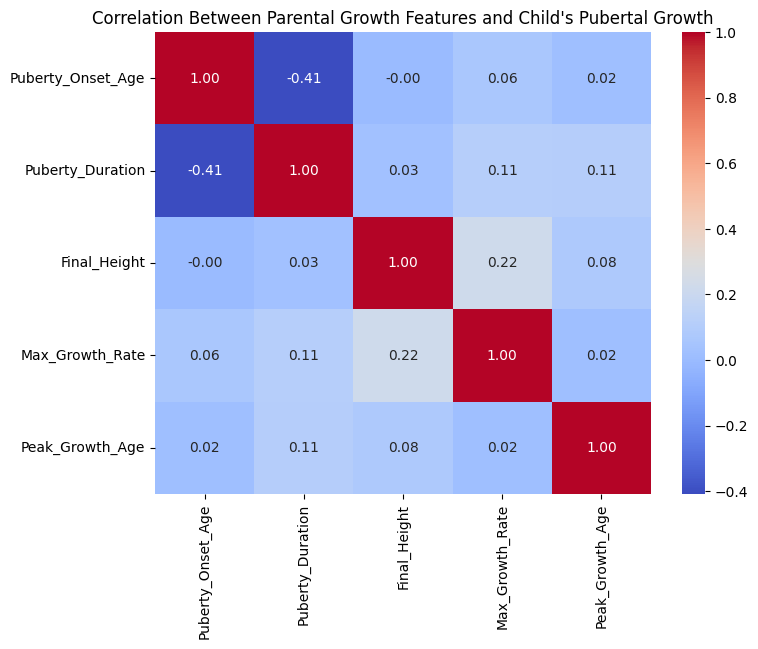

In [12]:
# Compute correlation matrix
correlation_matrix = merged_data[['Puberty_Onset_Age', 'Puberty_Duration', 'Final_Height', 'Max_Growth_Rate', 'Peak_Growth_Age']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Parental Growth Features and Child's Pubertal Growth")
plt.show()

In [13]:
# Prepare features and target variables
X = merged_data[['Final_Height', 'Max_Growth_Rate', 'Peak_Growth_Age']]
y_onset = merged_data['Puberty_Onset_Age']
y_duration = merged_data['Puberty_Duration']

# Add constant for regression
X_const = sm.add_constant(X)

# Run regression models
model_onset = sm.OLS(y_onset, X_const).fit()
model_duration = sm.OLS(y_duration, X_const).fit()

# Display regression results
model_onset_summary = model_onset.summary()
model_duration_summary = model_duration.summary()

print("Puberty Onset Age Model")
print(model_onset_summary)

Puberty Onset Age Model
                            OLS Regression Results                            
Dep. Variable:      Puberty_Onset_Age   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     77.35
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           6.42e-50
Time:                        22:20:02   Log-Likelihood:                -97828.
No. Observations:               53240   AIC:                         1.957e+05
Df Residuals:                   53236   BIC:                         1.957e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             

In [14]:
print("Puberty Duration Model")
print(model_duration_summary)

Puberty Duration Model
                            OLS Regression Results                            
Dep. Variable:       Puberty_Duration   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     415.0
Date:                Sun, 02 Mar 2025   Prob (F-statistic):          1.63e-266
Time:                        22:20:02   Log-Likelihood:                -57475.
No. Observations:               53240   AIC:                         1.150e+05
Df Residuals:                   53236   BIC:                         1.150e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              

In [17]:
# Load data
gen1_train = pd.read_csv(DATA_PATH + "gen1_train_comp_final.csv")
gen2_train = pd.read_csv(DATA_PATH + "gen2_train_comp_final.csv")

# Compute height velocity (growth rate) for parents
gen1_train['Height_Velocity'] = gen1_train.groupby('gen1_id')['SHgt_cm'].diff()

# Focus on puberty ages in children (9-15 years old)
gen2_puberty = gen2_train[(gen2_train['AgeGr'] >= 9) & (gen2_train['AgeGr'] <= 15)].copy()

# Compute height velocity for children
gen2_puberty['Height_Velocity'] = gen2_puberty.groupby('gen2_id')['SHgt_cm'].diff()

# Define growth spurt threshold (75th percentile of height velocity)
growth_threshold = gen2_puberty['Height_Velocity'].quantile(0.75)

# Identify puberty onset age (first year of rapid growth)
puberty_onset = (
    gen2_puberty[gen2_puberty['Height_Velocity'] > growth_threshold]
    .groupby('gen2_id')['AgeGr']
    .min()
    .reset_index()
)
puberty_onset.columns = ['gen2_id', 'Puberty_Onset_Age']

# Extract parental growth features
gen1_features = (
    gen1_train
    .groupby('gen1_id')
    .agg(
        Final_Height=('SHgt_cm', 'max'),
        Max_Growth_Rate=('Height_Velocity', 'max'),
        Peak_Growth_Age=('age', lambda x: x.iloc[np.argmax(gen1_train.loc[x.index, 'Height_Velocity'])]),
    ).reset_index()
)
gen1_features.rename(columns={'gen1_id': 'study_parent_id_new'}, inplace=True)

# Merge child and parent data
merged_data = (
    puberty_onset
    .merge(gen2_train[['gen2_id', 'study_parent_id_new', 'sex_assigned_at_birth']], on='gen2_id')
    .merge(gen1_features, on='study_parent_id_new')
    .merge(gen1_train[['gen1_id', 'sex_assigned_at_birth']], left_on='study_parent_id_new', right_on='gen1_id', suffixes=('_child', '_parent'))
    .drop(columns=['gen1_id'])
)

# **Create a categorical variable for parent-child sex groups using One-Hot Encoding**
merged_data['Sex_Group'] = merged_data['sex_assigned_at_birth_child'] + "_" + merged_data['sex_assigned_at_birth_parent']

# Fit OLS model using statsmodels formula API with one-hot encoding and interaction terms
formula = """
    Puberty_Onset_Age ~ Final_Height + Max_Growth_Rate + Peak_Growth_Age + 
    C(Sex_Group) + 
    Final_Height:C(Sex_Group) + Max_Growth_Rate:C(Sex_Group) + Peak_Growth_Age:C(Sex_Group)
"""

# Fit the model
model = smf.ols(formula, data=merged_data).fit()

# Display regression summary
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Puberty_Onset_Age   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     6403.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:36:12   Log-Likelihood:            -1.2945e+05
No. Observations:               87120   AIC:                         2.589e+05
Df Residuals:                   87105   BIC:                         2.591e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               8.7466      0.294     29.716      0.000       8.170       9.324
C(Sex_Group)[T.F_M]                     3.1895      0.376      8.493      0.000       2.453       3.926
C(Sex_Group)[T.M_F]                    -0.2726      0.037     -7.329      0.000      -0.345      -0.200
C(Sex_Group)[T.M_M]                     2.5955      0.365      7.120      0.000       1.881       3.310
Final_Height                            0.0448      0.002     25.676      0.000       0.041       0.048
Final_Height:C(Sex_Group)[T.F_M]       -0.0467      0.002    -20.877      0.000      -0.051      -0.042
Final_Height:C(Sex_Group)[T.M_F]       -0.0045      0.002     -2.122      0.034      -0.009      -0.000
Final_Height:C(Sex_Group)[T.M_M]       -0.0377      0.002    -18.608      0.000      -0.042      -0.034
Max_Growth_Rate                        -0.4310      0.006    -67.226      0.000      -0.444      -0.418
Max_Growth_Rate:C(Sex_Group)[T.F_M]     0.3829      0.010     38.476      0.000       0.363       0.402
Max_Growth_Rate:C(Sex_Group)[T.M_F]     0.5921      0.009     63.189      0.000       0.574       0.610
Max_Growth_Rate:C(Sex_Group)[T.M_M]     0.4566      0.009     48.870      0.000       0.438       0.475
Peak_Growth_Age                        -0.1763      0.006    -27.730      0.000      -0.189      -0.164
Peak_Growth_Age:C(Sex_Group)[T.F_M]     0.2171      0.011     18.991      0.000       0.195       0.240
Peak_Growth_Age:C(Sex_Group)[T.M_F]    -0.8177      0.112     -7.329      0.000      -1.036      -0.599
Peak_Growth_Age:C(Sex_Group)[T.M_M]     0.3075      0.027     11.489      0.000       0.255       0.360
==============================================================================
Omnibus:                      474.817   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.117
Skew:                          -0.181   Prob(JB):                    2.04e-105
Kurtosis:                       2.958   Cond. No.                     3.98e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.04e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
# Compute puberty duration (number of years with high growth rate)
puberty_duration = (
    gen2_puberty[gen2_puberty['Height_Velocity'] > growth_threshold]
    .groupby('gen2_id')['AgeGr']
    .count()
    .reset_index()
)
puberty_duration.columns = ['gen2_id', 'Puberty_Duration']

# Merge puberty onset and duration data
gen2_puberty_info = puberty_onset.merge(puberty_duration, on='gen2_id')

# Merge with parental data
merged_data = (
    gen2_puberty_info
    .merge(gen2_train[['gen2_id', 'study_parent_id_new', 'sex_assigned_at_birth']], on='gen2_id')
    .merge(gen1_features, on='study_parent_id_new')
    .merge(gen1_train[['gen1_id', 'sex_assigned_at_birth']], left_on='study_parent_id_new', right_on='gen1_id', suffixes=('_child', '_parent'))
    .drop(columns=['gen1_id'])
)

# **Recreate the categorical variable for parent-child sex groups using One-Hot Encoding**
merged_data['Sex_Group'] = merged_data['sex_assigned_at_birth_child'] + "_" + merged_data['sex_assigned_at_birth_parent']

# Fit OLS model for Puberty Duration
formula_duration = """
    Puberty_Duration ~ Final_Height + Max_Growth_Rate + Peak_Growth_Age + 
    C(Sex_Group) + 
    Final_Height:C(Sex_Group) + Max_Growth_Rate:C(Sex_Group) + Peak_Growth_Age:C(Sex_Group)
"""

# Fit the model
model_duration = smf.ols(formula_duration, data=merged_data).fit()

# Display regression summary
model_duration.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Puberty_Duration   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:38:49   Log-Likelihood:                -91036.
No. Observations:               87120   AIC:                         1.821e+05
Df Residuals:                   87105   BIC:                         1.822e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.0315      0.189     10.726      0.000       1.660       2.403
C(Sex_Group)[T.F_M]                    -4.1993      0.242    -17.378      0.000      -4.673      -3.726
C(Sex_Group)[T.M_F]                     0.5832      0.024     24.368      0.000       0.536       0.630
C(Sex_Group)[T.M_M]                    -0.1054      0.235     -0.449      0.653      -0.565       0.354
Final_Height                           -0.0136      0.001    -12.114      0.000      -0.016      -0.011
Final_Height:C(Sex_Group)[T.F_M]        0.0338      0.001     23.487      0.000       0.031       0.037
Final_Height:C(Sex_Group)[T.M_F]       -0.0236      0.001    -17.149      0.000      -0.026      -0.021
Final_Height:C(Sex_Group)[T.M_M]        0.0087      0.001      6.648      0.000       0.006       0.011
Max_Growth_Rate                         0.1589      0.004     38.513      0.000       0.151       0.167
Max_Growth_Rate:C(Sex_Group)[T.F_M]    -0.1424      0.006    -22.229      0.000      -0.155      -0.130
Max_Growth_Rate:C(Sex_Group)[T.M_F]    -0.1753      0.006    -29.080      0.000      -0.187      -0.164
Max_Growth_Rate:C(Sex_Group)[T.M_M]    -0.1270      0.006    -21.125      0.000      -0.139      -0.115
Peak_Growth_Age                         0.1199      0.004     29.301      0.000       0.112       0.128
Peak_Growth_Age:C(Sex_Group)[T.F_M]    -0.1318      0.007    -17.917      0.000      -0.146      -0.117
Peak_Growth_Age:C(Sex_Group)[T.M_F]     1.7495      0.072     24.368      0.000       1.609       1.890
Peak_Growth_Age:C(Sex_Group)[T.M_M]     0.0501      0.017      2.907      0.004       0.016       0.084
==============================================================================
Omnibus:                     3432.859   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3669.325
Skew:                           0.483   Prob(JB):                         0.00
Kurtosis:                       2.724   Cond. No.                     3.98e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.04e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""